In [ ]:
!pip install pandas_datareader

In [ ]:
!pip install -U kaleido

# **Легенда**

Вы - успешный специалист в области datascience и вас наняла риэлторская компания, размещающая объявления о продаже/аренде домов на популярном сайте для объявлений vatio.org. Вам требуется обучить модель, которая сможет предсказать популярность объявления - исходя из этих предсказаний аналитики риэлторской компании будут редактировать описания объявлений, выставляемых на этой платформе.

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader.data as web
from sklearn.model_selection import train_test_split

In [4]:
houses_ads_df = pd.read_csv('houses_ads_popularity.csv')
houses_ads_df.head(5)

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,TARGET
0,57094,1.0,3,0,2016-05-19 18:06:27,A FABULOUS 3BR IN MIDTOWN WEST! PERFECT APAR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,W 50 & AVE 10,medium
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,Renovated Kitchen and Bathroom!,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,['https://photos.renthop.com/2/7166774_03cf63a...,2570,55 River Drive South,medium
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,RARE AND BEST DEAL ON THE MARKET!!!! PERFECT S...,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,22 W 77 Street,low
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,Newly renovated flex 2 apartment offers the ne...,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,100 John Street,low
4,592,1.0,3,fee4d465932160318364d9d48d272879,2016-06-16 06:06:15,LOW FEE apartments do not come around like thi...,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,6fba9b3a8327c607b8b043716efee684,['https://photos.renthop.com/2/7170465_9c3f173...,5695,321 West 16th Street,low


#**1 часть**
**Feature engineering** - необходимо заполнить пропуски в данных, обработать категориальные признаки и т.д.

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

_Выполним обработку признаков, которая никак не приведет к утечке данных: заменим текстовые данные на информацию об их наличии, заменим массивы в ячейкак на их длину, удалим признаки, которые не несут важной информации_

In [6]:
# Проверка столбцов на наличие в них пропусков

houses_ads_df.isna().any()

Id                 False
bathrooms          False
bedrooms           False
building_id        False
created            False
description         True
display_address     True
features           False
latitude           False
listing_id         False
longitude          False
manager_id         False
photos             False
price              False
street_address      True
TARGET             False
dtype: bool

_Пропуски в данных есть в столбцах description, display_address, street_address_

In [7]:
# Заменим данные в столбцах description, display_address, street_address на 0, если в ячейке пропуск, на 1, если ячейка не пустая

houses_ads_df.loc[houses_ads_df["description"].isna(), ["is_there_description"]] = 0
houses_ads_df.loc[houses_ads_df["description"].isna()==False, ["is_there_description"]] = 1
houses_ads_df.loc[houses_ads_df["display_address"].isna(), ["is_there_display_address"]] = 0
houses_ads_df.loc[houses_ads_df["display_address"].isna()==False, ["is_there_display_address"]] = 1
houses_ads_df.loc[houses_ads_df["street_address"].isna(), ["is_there_street_address"]] = 0
houses_ads_df.loc[houses_ads_df["street_address"].isna()==False, ["is_there_street_address"]] = 1
houses_ads_df = houses_ads_df.drop(columns=["description", "display_address", "street_address"])

_Теперь пропусков в данных нет_

In [8]:
# Заменим массивы в столбцах features и photos на их длину (количество признаков/фотографий)

houses_ads_df["number_of_features"] = houses_ads_df['features'].apply(eval).apply(len)
houses_ads_df["number_of_photos"] = houses_ads_df['photos'].apply(eval).apply(len)
houses_ads_df = houses_ads_df.drop(columns=["features", "photos"])

In [9]:
# Удалим столбцы Id и listing_id, тк они не несут в себе дополнительной информации, а просто содержат уникальные числа для каждой строки

houses_ads_df = houses_ads_df.drop(columns=["Id", "listing_id"])

_Закодируем категориальные признаки manager_id, building_id. Все правила кодировки выводятся по обучающей выборке, а затем применяются на тестовую, чтобы не допустить утечки данных из тестовой выборки_

In [10]:
# Разделим выборку на тестовую и обучающую

data_train, data_test = train_test_split(houses_ads_df, test_size=0.2, random_state=0)

X_train = data_train.drop(["TARGET"], axis=1)
X_test = data_test.drop(["TARGET"], axis=1)
y_train = data_train["TARGET"]
y_test = data_test["TARGET"]

In [11]:
# Кодируем категориальные признаки по обучающей выборке

enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
columns_to_one_hot = ["manager_id", "building_id"]
enc.fit(X_train.loc[:, columns_to_one_hot])
encoded_array = enc.transform(houses_ads_df.loc[:, columns_to_one_hot])
df_encoded = pd.DataFrame(encoded_array, columns=enc.get_feature_names_out())
df_sklearn_encoded = pd.concat([houses_ads_df, df_encoded], axis=1)
df_sklearn_encoded.drop(labels=columns_to_one_hot, axis=1, inplace=True)

In [12]:
# Закодируем TARGET: low - 1, medium - 2, high - 3

df_sklearn_encoded.loc[df_sklearn_encoded["TARGET"]=='low', ["TARGET"]] = 1
df_sklearn_encoded.loc[df_sklearn_encoded["TARGET"]=='medium', ["TARGET"]] = 2
df_sklearn_encoded.loc[df_sklearn_encoded["TARGET"]=='high', ["TARGET"]] = 3

In [13]:
# Переведем created в количество дней от создания до текущей даты, выведем месяц, день и час в отдельные признаки. Год везде одинаковый,
# так что не будем его учитывать

df_sklearn_encoded["created"] = df_sklearn_encoded["created"].apply(pd.to_datetime)
df_sklearn_encoded["month"] = df_sklearn_encoded["created"].dt.month
df_sklearn_encoded["day_in_month"] = df_sklearn_encoded["created"].dt.day
df_sklearn_encoded["hour"] = df_sklearn_encoded["created"].dt.hour
now = dt.datetime.now()
df_sklearn_encoded["how_long_ago_created"] = df_sklearn_encoded["created"].apply(lambda x: (now-x).days)
df_sklearn_encoded = df_sklearn_encoded.drop(columns=["created"])

_Можно было бы закодировать координаты, через страну, но для такой большой выборке это занимает очень много времени_   
_Нормализуем данные:_

In [14]:
# Нормализуем данные в столбцах, где значения могут быть отлины от 0 и 1, через MinMaxScaler

train_index = X_train.index
test_index = X_test.index

scaler = preprocessing.MinMaxScaler()

names = ['bathrooms', 'bedrooms', 'how_long_ago_created', 'hour', 'month', 'day_in_month', 'latitude', 'longitude', 'price', 'number_of_features', 'number_of_photos']
scaler.fit(df_sklearn_encoded.loc[train_index, names])
tmp = scaler.transform(df_sklearn_encoded.loc[:, names])

df_sklearn_encoded = pd.concat([df_sklearn_encoded.drop(columns=names), pd.DataFrame(tmp, columns=names)], axis=1)

In [15]:
# Обновим тестовую и обучающую выборки

train_index = X_train.index
test_index = X_test.index

X_train_enc = df_sklearn_encoded.iloc[train_index, :].drop(["TARGET"], axis=1)
X_test_enc = df_sklearn_encoded.iloc[test_index, :].drop(["TARGET"], axis=1)
y_train_enc = df_sklearn_encoded.loc[train_index, ["TARGET"]]
y_test_enc = df_sklearn_encoded.loc[test_index, ["TARGET"]]

In [16]:
X_train_enc.sample(5)

,is_there_description,is_there_display_address,is_there_street_address,manager_id_0000abd7518b94c35a90d64b56fbf3e6,manager_id_001ce808ce1720e24a9510e014c69707,manager_id_003fc4e9a70053082f131b1054966aaf,manager_id_00607a02f6efd9c6c7c588826e471ee9,manager_id_00995ff28d79127ed2dca8320e9e7d09,manager_id_00a8d77892cab18fffaa22a751f1f8eb,manager_id_00f0b3346ba8379b26b95be8a19d46b1,...,bedrooms,how_long_ago_created,hour,month,day_in_month,latitude,longitude,price,number_of_features,number_of_photos
22940,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.382022,0.130435,0.5,0.866667,0.914216,0.020863,0.000781,0.111111,0.304348
34034,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.786517,0.260870,0.0,0.666667,0.913458,0.020343,0.001549,0.222222,0.195652
27303,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.078652,0.130435,1.0,0.733333,0.913743,0.020634,0.000736,0.194444,0.152174
10950,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.988764,0.086957,0.0,0.066667,0.913153,0.020324,0.000630,0.083333,0.108696
18439,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.483146,0.043478,0.5,0.566667,0.913427,0.020176,0.000480,0.083333,0.021739


_Обработка признаков завершена_  
  
**Вывод:** _удалены все признаки, из которых трудно вывести полезную информацию; все категориальные признаки закодированы так, чтобы их можно было использовать; все числовые признаки нормализованы_

# **2 часть**  
**EDA** - необходимо исследовать данные в предлагаемом Вам датасете. К исследованию данных относится анализ распределения значений в признаках, проверка скоррелированности признаков и т.д.

In [17]:
import scipy.stats as st
from scipy.stats.stats import pearsonr
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

In [18]:
# Проверка корреляции между некотегориальными признаками

names = ['bathrooms', 'bedrooms', 'how_long_ago_created', 'hour', 'month', 'day_in_month', 'latitude', 'longitude', 'price', 'number_of_features', 'number_of_photos']
no_correlation = []
correlation = []

for i in range(len(names)):
  for j in range(i+1, len(names)):
    print(f'Correlation test for {names[i]} and {names[j]}')
    corr, p = pearsonr(X_train_enc[names[i]], X_train_enc[names[j]])
    print("p-value for significance is: ", p)
    print("correlation is: ", corr)

    if p > 0.05:
      no_correlation.append([names[i], names[j]])
      print("No correlation\n")
    else:
      correlation.append([names[i], names[j]])
      print("Correlation\n")

print("Pairs of features without correlation: ", no_correlation)
print("Pairs of features with correlation: ", correlation)

Correlation test for bathrooms and bedrooms
p-value for significance is:  0.0
correlation is:  0.5341828360113188
Correlation

Correlation test for bathrooms and how_long_ago_created
p-value for significance is:  0.6381469877061254
correlation is:  -0.0028290982536954994
No correlation

Correlation test for bathrooms and hour
p-value for significance is:  0.036520696559973004
correlation is:  -0.012578706280078483
Correlation

Correlation test for bathrooms and month
p-value for significance is:  0.988181591608654
correlation is:  -8.910803434796638e-05
No correlation

Correlation test for bathrooms and day_in_month
p-value for significance is:  0.08456351663903783
correlation is:  0.010375501903195996
No correlation

Correlation test for bathrooms and latitude
p-value for significance is:  6.325457450132603e-06
correlation is:  -0.027156871713079067
Correlation

Correlation test for bathrooms and longitude
p-value for significance is:  3.450409626189413e-06
correlation is:  0.02791921

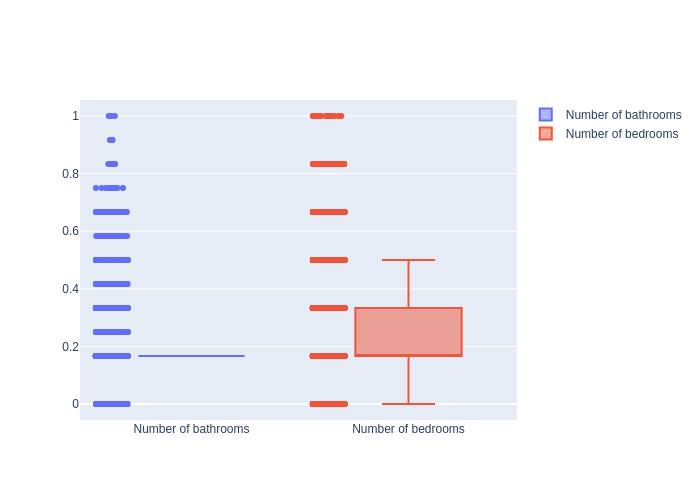

In [19]:
# Построение диаграммы размаха зависимости количества спален от количества ванных

fig = go.Figure()
fig.add_trace(go.Box(y=X_train_enc['bathrooms'].tolist(), name="Number of bathrooms", boxpoints='all'))
fig.add_trace(go.Box(y=X_train_enc['bedrooms'].tolist(), name="Number of bedrooms", boxpoints='all'))
fig.show('png')

_Диаграмма размаха показывает, что признаки схожи не так сильно_

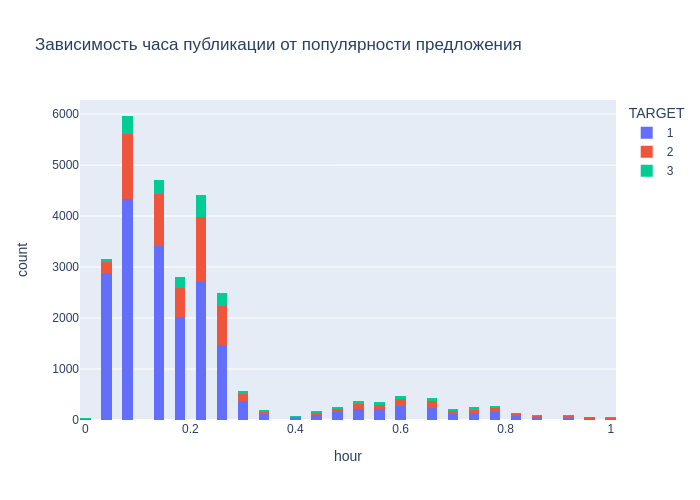

In [20]:
# Построим гистограмму, отображающую зависимость популярности предложения от часа публикации (признаки нормированные, поэтому чем выше
# цифра TARGET, тем популярнее предложение, часы распределены от 0 до 1) 

fig = px.histogram(pd.concat([X_train_enc["hour"], y_train_enc], axis=1), x="hour", color="TARGET", title="Зависимость часа публикации от популярности предложения")
fig.show('png')

_Возможно наличие информации о месяце, дне и часе создания предлоения избыточна, это показывает корреляция с признаком давности создания. Удалим их_

In [21]:
# Удаляем лишние признаки

X_train_enc = X_train_enc.drop(columns=['hour', 'month', 'day_in_month'])
X_test_enc = X_test_enc.drop(columns=['hour', 'month', 'day_in_month'])

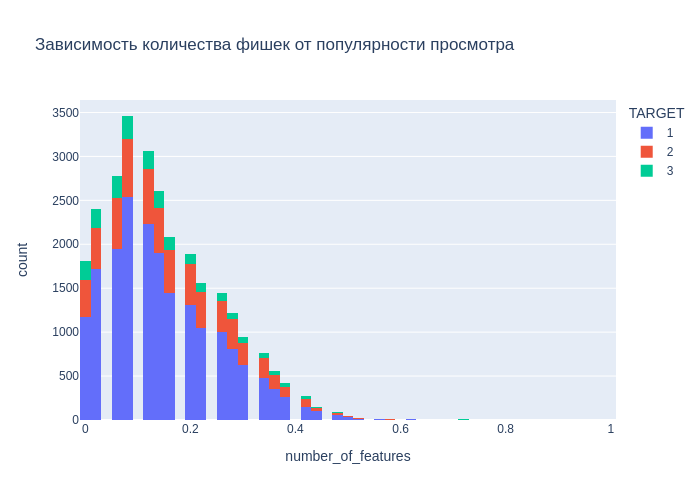

In [22]:
# Построим гистограмму, отображающую зависимость популярности предложения от количества фишек (признаки нормированные, поэтому чем выше
# цифра TARGET, тем популярнее предложение, количество фишек распределено от 0 до 1) 

fig = px.histogram(pd.concat([X_train_enc["number_of_features"], y_train_enc], axis=1), x="number_of_features", color="TARGET", title="Зависимость количества фишек от популярности просмотра")
fig.show('png')

In [23]:
X_train = X_train_enc
X_test = X_test_enc
#y_train = y_train_enc.astype('int')
#y_test = y_test_enc.astype('int')

**Вывод:** _среди признаков есть скоррелированые, но складывается ощущение, что по большей части среди них нет каузации. Некоторые признаки удалили, но оставим большую часть_

# **3 часть**
**Выбор целевой метрики** - необходимо выбрать метрику качества, которую вы будете оптимизировать. Для выбранной метрики необходимо написать пояснение. В этом задании нет единственного правильного ответа, однако за откровенно неадекватный выбор или слабую аргументацию будут снижаться баллы.

_У нас стоит задача классификации, поэтому будем рассматривать метрики: f1, accuracy и confusion matrix. Наиболее наглядная и при этом учитывающая наибольшее количество параметров - f1_  
  
**Вывод:** _попробуем оптимизировать метрику f1_

# **4 часть**
**Проведение экспериментов** - необходимо попробовать разные модели, изученные в рамках курса и оптимизировать ими выбранную вами целевую метрику. Решение, состоящее только из grid-search по гиперпараметрам Catboost, получает 0 баллов.

In [ ]:
!pip install catboost

In [25]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier

In [26]:
catboosting = CatBoostClassifier(metric_period=50, random_state=42)
catboosting.fit(X_train, y_train)
y_pred = catboosting.predict(X_test)

print(classification_report(list(y_test.values), y_pred, digits=4))

Learning rate set to 0.093721
0:	learn: 1.0300384	total: 210ms	remaining: 3m 29s
50:	learn: 0.6388351	total: 6.74s	remaining: 2m 5s
100:	learn: 0.6160417	total: 13.6s	remaining: 2m 1s
150:	learn: 0.6012226	total: 19.4s	remaining: 1m 48s
200:	learn: 0.5917134	total: 26.1s	remaining: 1m 43s
250:	learn: 0.5852582	total: 29.8s	remaining: 1m 28s
300:	learn: 0.5803347	total: 32.6s	remaining: 1m 15s
350:	learn: 0.5762092	total: 35.4s	remaining: 1m 5s
400:	learn: 0.5726150	total: 38.3s	remaining: 57.2s
450:	learn: 0.5698205	total: 41.1s	remaining: 50s
500:	learn: 0.5668755	total: 43.9s	remaining: 43.7s
550:	learn: 0.5644459	total: 46.7s	remaining: 38s
600:	learn: 0.5614100	total: 49.5s	remaining: 32.9s
650:	learn: 0.5592704	total: 52.3s	remaining: 28.1s
700:	learn: 0.5569495	total: 55.2s	remaining: 23.5s
750:	learn: 0.5549180	total: 58s	remaining: 19.2s
800:	learn: 0.5530397	total: 1m	remaining: 15.1s
850:	learn: 0.5513240	total: 1m 3s	remaining: 11.2s
900:	learn: 0.5497617	total: 1m 9s	remain

In [27]:
# Функция для вывода результатов классификации

def class_function(classifier, X_train, y_train, X_test, y_test):
    model = classifier
    model.fit(X_train, list(y_train.values))
    y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)

    print(f"--Classifier: {classifier}--")
    print(f'f1_score: {f1_score(y_test, y_pred_test, average = "weighted")}')
    print(f'accuracy_score: {accuracy_score(y_test, y_pred_test)}')
    print(f'confusion_matrix:\n{confusion_matrix(list(y_test.values), y_pred_test)}\n')

_Посмотрим на результаты стандартных классификаторов_

In [28]:
# Линейные опорные вектора
class_function(LinearSVC(), X_train, y_train, X_test, y_test)

# Дерево
class_function(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

--Classifier: LinearSVC()--
f1_score: 0.6776476587040606
accuracy_score: 0.702315484804631
confusion_matrix:
[[  99  230  201]
 [  55 4233  481]
 [ 111  979  521]]

--Classifier: DecisionTreeClassifier()--
f1_score: 0.6866555976963833
accuracy_score: 0.6931982633863966
confusion_matrix:
[[ 170  150  210]
 [ 105 3993  671]
 [ 153  831  627]]



_Посмотрим на результаты ансамблевых классификаторов_

In [29]:
# Бэггинг по дереву
class_function(BaggingClassifier(DecisionTreeClassifier(random_state = 42), random_state = 42), X_train, y_train, X_test, y_test)

--Classifier: BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  random_state=42)--
f1_score: 0.7009206152498779
accuracy_score: 0.7240231548480464
confusion_matrix:
[[ 159  171  200]
 [  50 4318  401]
 [ 117  968  526]]



In [30]:
# Бэггинг по лесу
class_function(BaggingClassifier(RandomForestClassifier(random_state = 42), random_state = 42), X_train, y_train, X_test, y_test)

--Classifier: BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                  random_state=42)--
f1_score: 0.6758674024181268
accuracy_score: 0.7260492040520984
confusion_matrix:
[[  95  277  158]
 [   7 4564  198]
 [  54 1199  358]]



In [31]:
# Градиентный бустинг
class_function(GradientBoostingClassifier(random_state = 42), X_train, y_train, X_test, y_test)

--Classifier: GradientBoostingClassifier(random_state=42)--
f1_score: 0.6714214327595435
accuracy_score: 0.7264833574529667
confusion_matrix:
[[  95  272  163]
 [  13 4604  152]
 [  41 1249  321]]



In [32]:
# Стэкинг по [tree, svc] и tree
class_function(StackingClassifier([("tree", DecisionTreeClassifier(random_state = 42)), ("svc", LinearSVC(random_state = 42))], 
                                  final_estimator = DecisionTreeClassifier(random_state = 42)), X_train, y_train, X_test, y_test)

# Стэкинг по [tree, svc] и svc
class_function(StackingClassifier([("tree", DecisionTreeClassifier(random_state = 42)), ("svc", LinearSVC(random_state = 42))], 
                                  final_estimator = LinearSVC(random_state = 42)), X_train, y_train, X_test, y_test)

--Classifier: StackingClassifier(estimators=[('tree',
                                DecisionTreeClassifier(random_state=42)),
                               ('svc', LinearSVC(random_state=42))],
                   final_estimator=DecisionTreeClassifier(random_state=42))--
f1_score: 0.6316685588849311
accuracy_score: 0.6327062228654124
confusion_matrix:
[[ 132  202  196]
 [ 216 3717  836]
 [ 202  886  523]]

--Classifier: StackingClassifier(estimators=[('tree',
                                DecisionTreeClassifier(random_state=42)),
                               ('svc', LinearSVC(random_state=42))],
                   final_estimator=LinearSVC(random_state=42))--
f1_score: 0.6708508916438938
accuracy_score: 0.7206946454413893
confusion_matrix:
[[  39  238  253]
 [   5 4522  242]
 [  23 1169  419]]



In [33]:
# Адаптивный бустинг
class_function(AdaBoostClassifier(LogisticRegression(random_state = 42)), X_train, y_train, X_test, y_test)

--Classifier: AdaBoostClassifier(base_estimator=LogisticRegression(random_state=42))--
f1_score: 0.5636388689285963
accuracy_score: 0.6901591895803184
confusion_matrix:
[[   0  530    0]
 [   0 4769    0]
 [   0 1611    0]]



_Лучший результат был на бэггинге по дереву, попробуем улучшить результат, подобрав гиперпараметры_

In [34]:
def bagging(parameter_bagging: str, values_bagging: list, X_train, X_test, y_train, y_test):
    for value in values_bagging:
      for max_depth in range(10, 21, 2):
        model = BaggingClassifier(DecisionTreeClassifier(max_depth=max_depth), **{parameter_bagging: value})
        model.fit(X_train, y_train)
        y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)
        print(f"--{parameter_bagging}: {value}; max_depth: {max_depth}--")
        print(f'f1_score: {f1_score(y_test, y_pred_test, average = "weighted")}\n')

In [35]:
#print("----n_estimators----")
#bagging('n_estimators', np.arange(2, 21, 2), X_train, X_test, y_train, y_test)

_Пришлось проверять гиперпараметры в другом ноутбуке, тк здесь слишком много нагрузки, результат такой:_

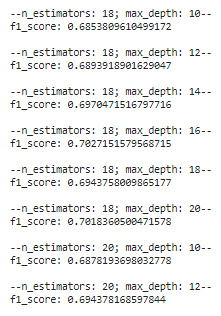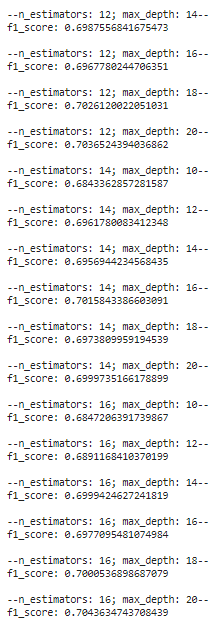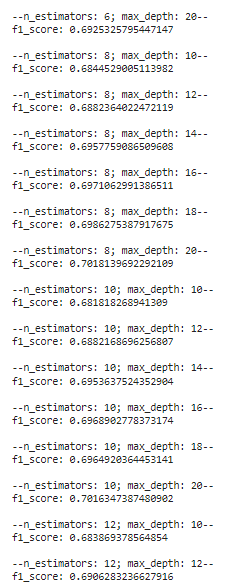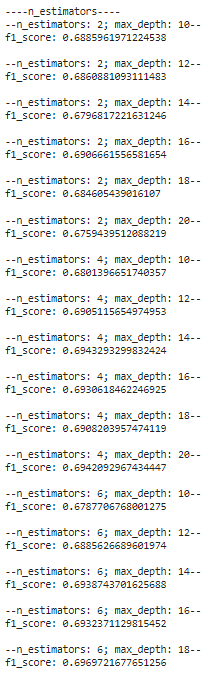

_Лучший результат при n_estimators: 16; max_depth: 20_

In [38]:
# Изначальный результат

model = BaggingClassifier(DecisionTreeClassifier(random_state = 42), random_state = 42)
model.fit(X_train, list(y_train.values))
y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)

print(f"--Classifier: {BaggingClassifier(DecisionTreeClassifier(random_state = 42), random_state = 42)}--")
print(f'f1_score: {f1_score(y_test, y_pred_test, average = "weighted")}')
print(f'accuracy_score: {accuracy_score(y_test, y_pred_test)}')
print(f'confusion_matrix:\n{confusion_matrix(list(y_test.values), y_pred_test)}\n')

--Classifier: BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  random_state=42)--
f1_score: 0.7009206152498779
accuracy_score: 0.7240231548480464
confusion_matrix:
[[ 159  171  200]
 [  50 4318  401]
 [ 117  968  526]]



In [43]:
# Бэггинг по дереву c учетом гиперпараметров (n_estimators: 16; max_depth: 20). Делаем не через функцию, чтобы сохранить предсказание

model = BaggingClassifier(DecisionTreeClassifier(random_state = 42, max_depth=20), random_state = 42, n_estimators=16)
model.fit(X_train, list(y_train.values))
y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)

print(f"--Classifier: {BaggingClassifier(DecisionTreeClassifier(random_state = 42, max_depth=18), random_state = 42, n_estimators=16)}--")
print(f'f1_score: {f1_score(y_test, y_pred_test, average = "weighted")}')
print(f'accuracy_score: {accuracy_score(y_test, y_pred_test)}')
print(f'confusion_matrix:\n{confusion_matrix(list(y_test.values), y_pred_test)}\n')

--Classifier: BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=18,
                                                        random_state=42),
                  n_estimators=16, random_state=42)--
f1_score: 0.697651096370905
accuracy_score: 0.7244573082489146
confusion_matrix:
[[ 133  175  222]
 [  30 4359  380]
 [  95 1002  514]]



_Результат получился хуже, чем исходный, возьмем второй по качеству набор гиперпараметров_

In [44]:
# Бэггинг по дереву c учетом гиперпараметров (n_estimators: 18; max_depth: 20). Делаем не через функцию, чтобы сохранить предсказание

model = BaggingClassifier(DecisionTreeClassifier(random_state = 42, max_depth=20), random_state = 42, n_estimators=18)
model.fit(X_train, list(y_train.values))
y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)

print(f"--Classifier: {BaggingClassifier(DecisionTreeClassifier(random_state = 42, max_depth=18), random_state = 42, n_estimators=16)}--")
print(f'f1_score: {f1_score(y_test, y_pred_test, average = "weighted")}')
print(f'accuracy_score: {accuracy_score(y_test, y_pred_test)}')
print(f'confusion_matrix:\n{confusion_matrix(list(y_test.values), y_pred_test)}\n')

--Classifier: BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=18,
                                                        random_state=42),
                  n_estimators=16, random_state=42)--
f1_score: 0.7012123748155945
accuracy_score: 0.7277858176555716
confusion_matrix:
[[ 132  174  224]
 [  31 4369  369]
 [  91  992  528]]



_Получилось немного улучшить результат. Можно перебрать еще несколько гиперпараметров, но это очень долго, поэтому попробуем посмотреть на примеры, где модель дала неправильный ответ_

**Вывод:** _лучшего результата удалось достичь, используя бэггинг по дереву, перебрав несколько гиперпараметров_

#**5 часть**
**Анализ ошибок модели** - необходимо взять несколько примеров из тестовой части датасета, на которых модель дала неправильный ответ, и попытаться проанализировать их, найти закономерности, полученные выводы проверить на других примерах.

In [55]:
# Создадим датафрейм, состоящий только из элементов, на которых была ошибка

not_equal = pd.DataFrame(y_pred_test != y_test)
not_equal = not_equal[not_equal==True].dropna()
error = X_test.loc[not_equal.index, :]
error.sample(5)

,is_there_description,is_there_display_address,is_there_street_address,manager_id_0000abd7518b94c35a90d64b56fbf3e6,manager_id_001ce808ce1720e24a9510e014c69707,manager_id_003fc4e9a70053082f131b1054966aaf,manager_id_00607a02f6efd9c6c7c588826e471ee9,manager_id_00995ff28d79127ed2dca8320e9e7d09,manager_id_00a8d77892cab18fffaa22a751f1f8eb,manager_id_00f0b3346ba8379b26b95be8a19d46b1,...,building_id_fff0a02ad82421c226c6d6765a0dde57,building_id_fff5915444b98b72a44a9456901f083c,bathrooms,bedrooms,how_long_ago_created,latitude,longitude,price,number_of_features,number_of_photos
18,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.166667,0.000000,0.157303,0.914276,0.020748,0.000424,0.111111,0.130435
28991,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.166667,0.166667,0.696629,0.913628,0.020515,0.000679,0.166667,0.086957
3351,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.166667,0.333333,0.393258,0.913808,0.020196,0.000725,0.361111,0.173913
26880,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.166667,0.166667,0.707865,0.913418,0.020442,0.000546,0.194444,0.086957
31752,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.166667,0.333333,0.438202,0.913187,0.020358,0.000747,0.277778,0.239130


In [65]:
# Посмотрим каждый десятый признак датафрейма ошибок

columns = error.columns
for i in range(0, 8613, 10):
  print(f'{columns[i]}: {error.iloc[:, i].unique()}')

is_there_description: [1. 0.]
manager_id_01074bb974b125b65fa1b11a64c65135: [0.]
manager_id_01f1fadb85be52e12ffe3456b571fe5e: [0.]
manager_id_0319c8009f00e29f3d434c1dd1d25e74: [0. 1.]
manager_id_03fea70f5551838fed4d6fe32859efab: [0.]
manager_id_0492625ca98a35bd7d75849f6b4944ae: [0.]
manager_id_0577b9cf7d26e41800d814cb70b2bbf0: [0.]
manager_id_067687be0b9efedec0af4f163d2487dc: [0.]
manager_id_07c511151921e268b260a2bc96399704: [0.]
manager_id_08e9bc53025e9420adb4f038b43166c1: [0.]
manager_id_09703fead6059562ab26a3522f738f87: [0.]
manager_id_0a2670d4936ba82672ca782d8137e7ae: [0.]
manager_id_0ab238985a49334440f05fe80a5a565c: [0.]
manager_id_0b8a0fb573c92be71bc4e077aec9a570: [0. 1.]
manager_id_0c8cc24d93c15cc2b7505f4c153b4906: [0.]
manager_id_0d16d096ef1256ba3fdd6df87f8e98fe: [0.]
manager_id_0db6148efb87ded68e91c2960511439e: [0.]
manager_id_0e53b32a013810c4b3d86299425a658c: [0.]
manager_id_0f08ff6ab816344dc6686bdc305038ec: [0. 1.]
manager_id_1014a43e89b749c41b1385d09539b94d: [0.]
manager_id_

In [63]:
# Создадим датафрейм, состоящий только из элементов, на которых ошибки не было

index = X_test.index.tolist()
for ind in not_equal.index.tolist():
  index.remove(ind)
correct = X_test.loc[index, :]

In [67]:
# Посмотрим каждый десятый признак датафрейма без ошибок

columns = correct.columns
for i in range(0, 8613, 10):
  print(f'{columns[i]}: {correct.iloc[:, i].unique()}')

is_there_description: [1. 0.]
manager_id_01074bb974b125b65fa1b11a64c65135: [0.]
manager_id_01f1fadb85be52e12ffe3456b571fe5e: [0.]
manager_id_0319c8009f00e29f3d434c1dd1d25e74: [0. 1.]
manager_id_03fea70f5551838fed4d6fe32859efab: [0. 1.]
manager_id_0492625ca98a35bd7d75849f6b4944ae: [0. 1.]
manager_id_0577b9cf7d26e41800d814cb70b2bbf0: [0. 1.]
manager_id_067687be0b9efedec0af4f163d2487dc: [0.]
manager_id_07c511151921e268b260a2bc96399704: [0.]
manager_id_08e9bc53025e9420adb4f038b43166c1: [0. 1.]
manager_id_09703fead6059562ab26a3522f738f87: [0. 1.]
manager_id_0a2670d4936ba82672ca782d8137e7ae: [0. 1.]
manager_id_0ab238985a49334440f05fe80a5a565c: [0. 1.]
manager_id_0b8a0fb573c92be71bc4e077aec9a570: [0. 1.]
manager_id_0c8cc24d93c15cc2b7505f4c153b4906: [0.]
manager_id_0d16d096ef1256ba3fdd6df87f8e98fe: [0. 1.]
manager_id_0db6148efb87ded68e91c2960511439e: [0. 1.]
manager_id_0e53b32a013810c4b3d86299425a658c: [0.]
manager_id_0f08ff6ab816344dc6686bdc305038ec: [0.]
manager_id_1014a43e89b749c41b1385d095

_По выборке из 860 признаков видно, что среди элементов, где было ошибочное предсказание гораздо больше нулевых признаков_

_Посмотрим еще какие результаты наиболее вероятно предсказываются неправильно_

In [72]:
# Количество различных значений в тестовой выборке

y_test.value_counts()

low       4769
medium    1611
high       530
Name: TARGET, dtype: int64

In [71]:
# Количество различных значений среди ошибочных предсказаний

y_test[not_equal.index].value_counts()

medium    1083
low        400
high       398
Name: TARGET, dtype: int64

In [73]:
# Количество различных значений среди правильных предсказаний

y_test[correct.index].value_counts()

low       4369
medium     528
high       132
Name: TARGET, dtype: int64

In [76]:
# Количество различных значений во всей базе данных

y_test.append(y_train).value_counts()

low       23999
medium     7860
high       2687
Name: TARGET, dtype: int64

_Объявлений с низким уровнем популярности больше всего в тестовой выборке и на них меньше всего ошибок. Объявления средней и высокой популярности в большинстве случаев были предсказаны неправильно_

**Вывод:** _У модели есть проблемы с определением объявлений со средним и высоким уровнем популярности, но низкую популярность определяет достаточно хорошо. Также ошибки могут возникать в элементах, где встречается большая разреженность признаков (многие признаки равны нулю)_